REAL NVP for estimating of distribution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.functional as F
from torch import distributions
import torch.nn.parameter as Parameter

from sklearn import datasets,cluster,mixture
from sklearn.preprocessing import StandardScaler

In [30]:
net_s = lambda: nn.Sequential(nn.Linear(2,256),nn.LeakyReLU(),nn.Linear(256,256),nn.LeakyReLU(),nn.Linear(256,2),nn.Tanh())
net_t = lambda: nn.Sequential(nn.Linear(2,256),nn.LeakyReLU(),nn.Linear(256,256),nn.LeakyReLU(),nn.Linear(256,2))
prior = distributions.MultivariateNormal(torch.zeros(2),torch.eye(2)) # the distribution, whose samples are obtained easily p(z)
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32)) # 6 masks : 1 step - [0,1],[1,0],[0,1],[1,0],[0,1],[1,0] 

In [38]:
class RealNVP(nn.Module):
  
  def __init__(self,net_t,net_s,masks,prior):
    super(RealNVP,self).__init__()
    self.t = torch.nn.ModuleList([net_t() for _ in range(len(masks))])
    self.s = torch.nn.ModuleList([net_s() for _ in range(len(masks))])
    self.mask = nn.Parameter(masks,requires_grad=False)
    self.prior = prior

  def g(self,z): # from easy to hard
    x = z
    for i in range(len(self.t)): 
      x_ =  x*self.mask[i]
      s = self.s[i](x_)*(1 - self.mask[i]) # two is bettter than one
      t = self.t[i](x_)*(1 - self.mask[i]) # two is better than one
      x = x_ +   ((x*(1 - self.mask[i]))*torch.exp(s) + t)
    return x
  
  def f(self, x):
    log_det_J, z = x.new_zeros(x.shape[0]), x
    for i in reversed(range(len(self.t))):
      z_ = self.mask[i] * z
      s = self.s[i](z_) * (1-self.mask[i]) # two is better than one 
      t = self.t[i](z_) * (1-self.mask[i]) # two is better than one
      z = z_ +  (z*(1 - self.mask[i]) - t) * torch.exp(-s) 
      log_det_J -= s.sum(dim=1) # 
    return z, log_det_J

  def log_prob_of_MLE(self,x):
    z,log_jacobian = self.f(x)
    return self.prior.log_prob(z) + log_jacobian
  
  def sample(self,batchSize):
    z = self.prior.sample((batchSize,1)) # torch.tensor([batchSize])
    x = self.g(z)
    return x

In [39]:
flow = RealNVP(net_t,net_s,masks,prior)
flow.parameters

<bound method Module.parameters of RealNVP(
  (t): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=2, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): LeakyReLU(negative_slope=0.01)
      (4): Linear(in_features=256, out_features=2, bias=True)
    )
    (3): Sequential(
      (0): Linear(i

In [40]:
optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(5001): 
  flow.train()   
  noisy_moons = datasets.make_moons(n_samples=100, noise=.05)[0].astype(np.float32)
  loss = -flow.log_prob_of_MLE(torch.from_numpy(noisy_moons)).mean()
    
  optimizer.zero_grad()
  loss.backward(retain_graph=True)
  optimizer.step()
    
  if t % 500 == 0:
    print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 2.353
iter 500: loss = 0.762
iter 1000: loss = 0.395
iter 1500: loss = 0.410
iter 2000: loss = 0.338
iter 2500: loss = 0.324
iter 3000: loss = 0.388
iter 3500: loss = 0.381
iter 4000: loss = 0.242
iter 4500: loss = 0.402
iter 5000: loss = 0.337


Text(0.5, 1.0, '$X = g(z)$')

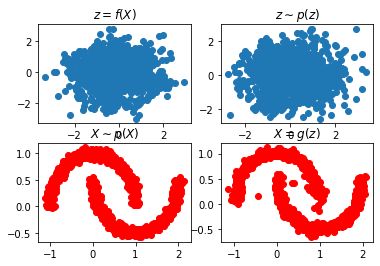

In [41]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')